<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio de Gestión de Outliers

AutoRenew, la empresa líder en la venta de coches de segunda mano, sigue adelante con el desarrollo del modelo predictivo que ayudará a estimar el precio de los vehículos usados. Este modelo es clave para mejorar las estrategias de ventas, marketing y optimización del inventario de la empresa. Ya has realizado un análisis exploratorio inicial y gestionado los valores nulos en el conjunto de datos. Ahora, es el momento de abordar otro aspecto crucial del preprocesamiento: la **gestión de outliers**.

En este laboratorio, te enfocarás en identificar y gestionar los outliers (valores atípicos) presentes en el conjunto de datos. Los outliers pueden distorsionar los resultados de un análisis y afectar negativamente el rendimiento de los modelos predictivos, por lo que es fundamental tratarlos adecuadamente antes de proceder con las siguientes fases del proyecto.


**Instrucciones:**

1. **Identificación de Outliers:** Explora las columnas clave del conjunto de datos (como `price`, `powerCV`, `kilometer`, etc.) para identificar posibles outliers. Utiliza gráficos como diagramas de caja (boxplots) y análisis estadísticos para detectar valores que se desvíen significativamente del resto de los datos.

2. **Análisis de Outliers:** Una vez identificados, analiza los outliers para determinar si son errores de datos, valores extremos válidos o resultados de condiciones específicas que deben ser tenidos en cuenta. Considera el contexto de cada columna al evaluar la relevancia de estos valores atípicos.

3. **Gestión de Outliers:** Decide la estrategia más adecuada para manejar los outliers. Esto podría incluir la eliminación de los outliers, la transformación de los datos, o la aplicación de técnicas de imputación. Justifica tu elección basándote en cómo los outliers podrían afectar el modelo predictivo.

**Nota:** Recuerda que este laboratorio es parte de una serie de actividades en las que utilizarás el mismo conjunto de datos a lo largo de la semana. Documenta cuidadosamente los pasos que sigas para que puedas referirte a ellos en las próximas etapas del proyecto.


In [34]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

import os
import sys 
sys.path.append(os.path.abspath("src"))   
import soporte_preprocesamiento as f
import warnings
warnings.filterwarnings("ignore")




# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor



from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler


from tqdm import tqdm


# import plotly_express as px


# Métodos estadísticos
# -----------------------------------------------------------------------
from scipy.stats import zscore # para calcular el z-score
from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF
from sklearn.neighbors import NearestNeighbors # para calcular la epsilon

# Para generar combinaciones de listas
# -----------------------------------------------------------------------
from itertools import product, combinations



In [6]:
df_robust=pd.read_csv("datos\datos_con_robust.csv", index_col=0)
df_robust.reset_index(drop=True, inplace=True)

In [11]:
df_robust["yearCreated"]=df_robust["yearCreated"].astype("category")
df_robust["monthCreated"]=df_robust["monthCreated"].astype("category")

In [12]:
df_robust.head(2)

,dateCrawled,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,model,monthOfRegistration,fuelType,brand,notRepairedDamage,lastSeen,yearCreated,monthCreated,powerCV_robust,kilometer_robust
0,2016-03-24 11:52:17,private,offer,480,test,other,moderno,manually,golf,desconocido,petrol,volkswagen,desconocido,2016-04-07 03:16:57,2016,3,0.076874,0.0
1,2016-03-24 10:58:45,private,offer,18300,test,coupe,actual,manually,desconocido,5,diesel,audi,yes,2016-04-07 01:46:50,2016,3,1.063492,-0.5


Primero identificamos los outliers en univariados

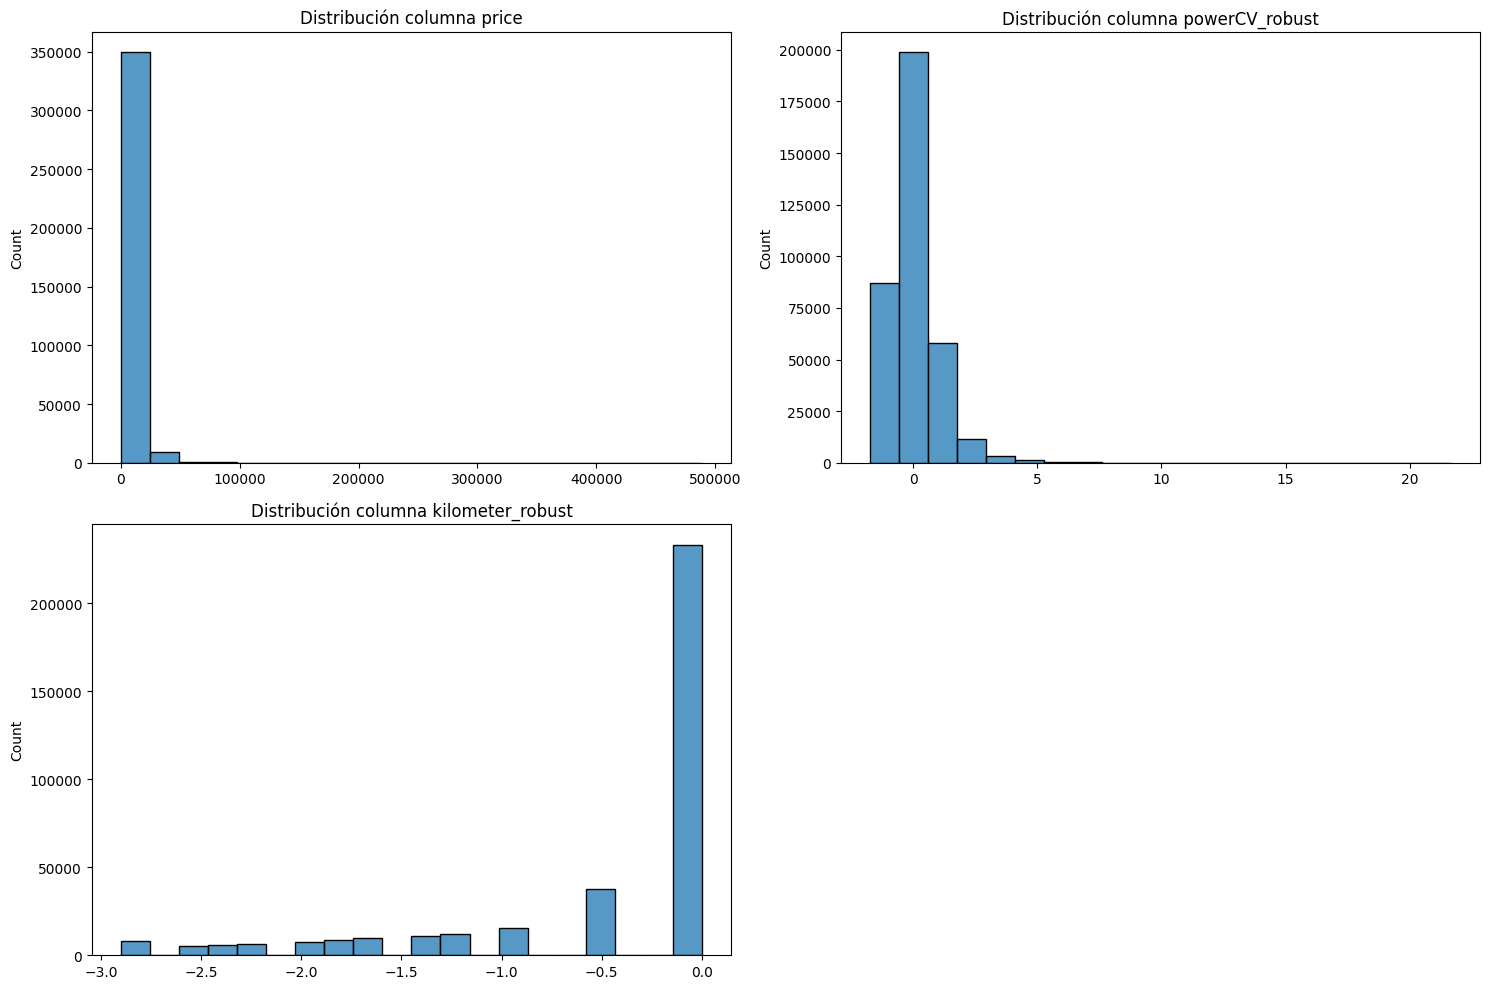

In [13]:
f.plot_outliers_univariados(df_robust, "h", (15,10))

Recuerdo la distribución de las numéricas ya seleccionadas mediante la metodología de escalador robusto

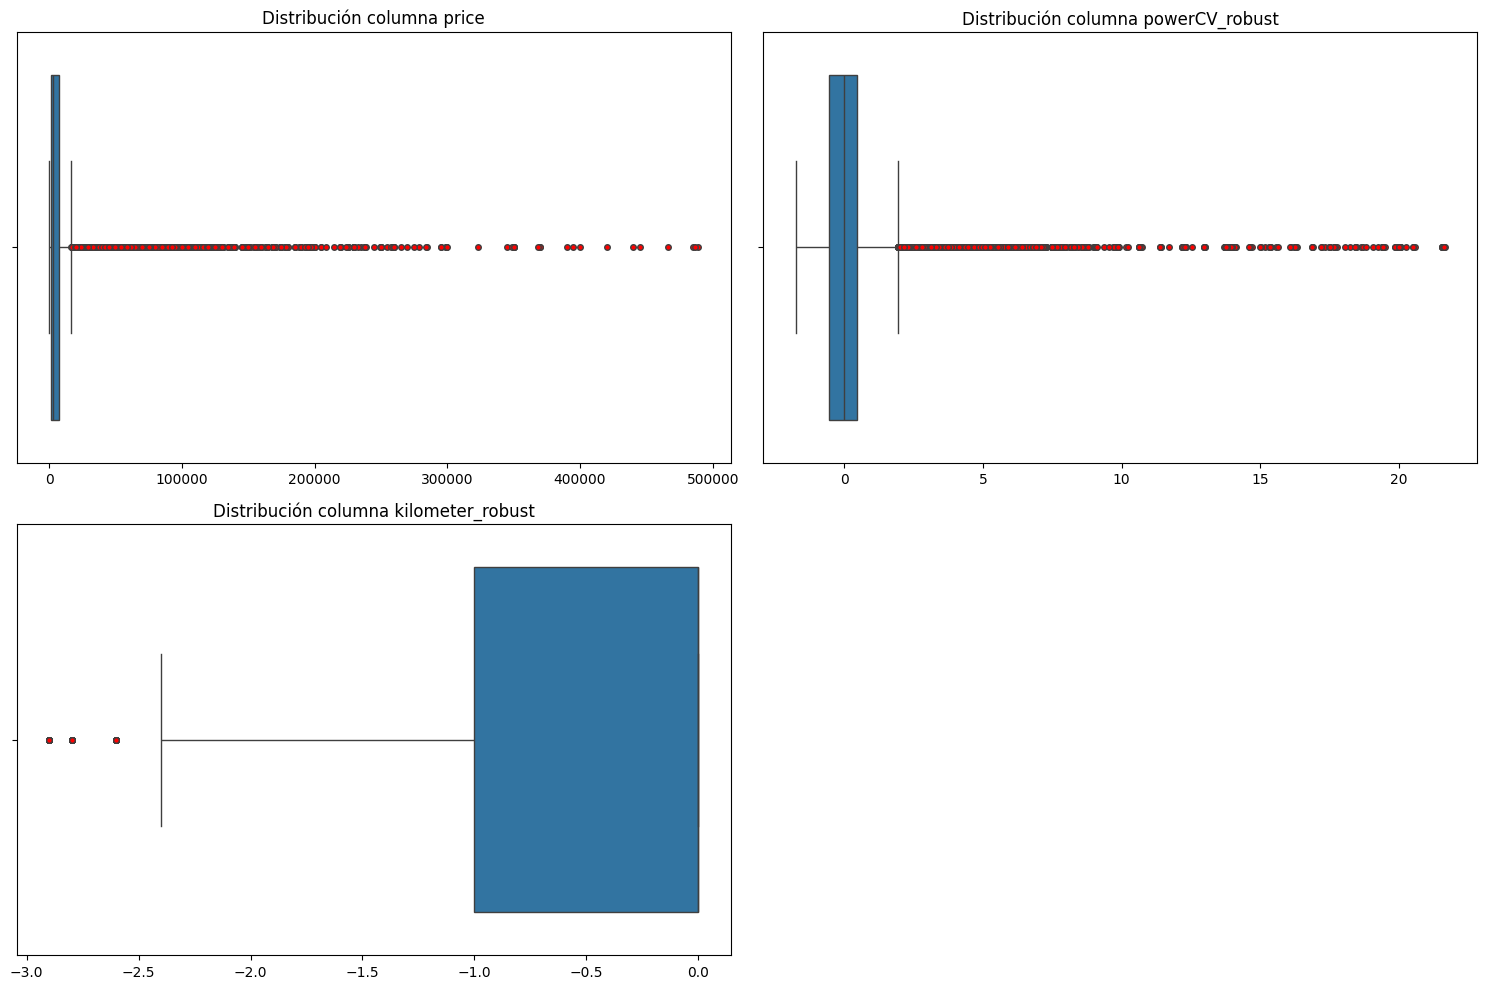

In [14]:
f.plot_outliers_univariados(df_robust, "b", (15,10))

Observo los outliers de las numéricas ya seleccionadas mediante la metodología de escalador robusto

In [15]:
num=df_robust.select_dtypes(include=np.number)
num.describe().T

,count,mean,std,min,25%,50%,75%,max
price,360644.0,5913.818220,9220.265780,1.000000,1250.000000,3000.0,7490.000000,488997.000000
powerCV_robust,360644.0,0.076874,0.976544,-1.746032,-0.555556,0.0,0.444444,21.666667
kilometer_robust,360644.0,-0.486559,0.796447,-2.900000,-1.000000,0.0,0.000000,0.000000


In [25]:
dicc_zsc=f.identificar_outliers_zscore(df_robust)

La cantidad de outliers para la PRICE es de 4512 outliers
La cantidad de outliers para la POWERCV_ROBUST es de 4940 outliers
La cantidad de outliers para la KILOMETER_ROBUST es de 6017 outliers


Dado que no tienen una distribución normal ninguna de ellas, no utilizaré el Z-Score ya que el porcentaje de fallo será demasiado alto. Por ello opto por el IQR

In [24]:
dicc_iqr=f.identificar_outliers_iqr(df_robust)

La columna PRICE tiene 26193 outliers
La columna POWERCV_ROBUST tiene 13194 outliers
La columna KILOMETER_ROBUST tiene 13419 outliers


In [20]:
dicc_iqr["price"].head(2)

,dateCrawled,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,model,monthOfRegistration,fuelType,brand,notRepairedDamage,lastSeen,yearCreated,monthCreated,powerCV_robust,kilometer_robust
1,2016-03-24 10:58:45,private,offer,18300,test,coupe,actual,manually,desconocido,5,diesel,audi,yes,2016-04-07 01:46:50,2016,3,1.063492,-0.5
13,2016-03-21 12:57:01,private,offer,17999,control,suv,actual,manually,navara,3,diesel,nissan,no,2016-04-06 07:45:42,2016,3,1.063492,-1.6


In [21]:
dicc_iqr["powerCV_robust"].head(2)

,dateCrawled,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,model,monthOfRegistration,fuelType,brand,notRepairedDamage,lastSeen,yearCreated,monthCreated,powerCV_robust,kilometer_robust
39,2016-03-30 20:38:20,private,offer,7500,control,other,moderno,automatic,e_klasse,4,other,mercedes_benz,desconocido,2016-04-03 11:44:49,2016,3,2.888889,0.0
54,2016-03-21 01:59:07,private,offer,39600,test,coupe,actual,automatic,andere,7,petrol,bmw,no,2016-04-03 23:16:31,2016,3,2.888889,-2.4


In [22]:
dicc_iqr["kilometer_robust"].head(2)

,dateCrawled,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,model,monthOfRegistration,fuelType,brand,notRepairedDamage,lastSeen,yearCreated,monthCreated,powerCV_robust,kilometer_robust
14,2016-03-11 21:39:15,private,offer,450,test,small car,clasico,desconocido,ka,desconocido,petrol,ford,desconocido,2016-03-19 08:46:47,2016,3,0.076874,-2.9
27,2016-03-09 11:56:38,private,offer,1990,test,bus,retro,manually,transporter,1,petrol,volkswagen,no,2016-03-10 07:44:33,2016,3,-1.126984,-2.9


Observamos como el número de outliers es muy elevado por lo general y no parecen estar muy separados entre ellos. Esto me lleva a pensar que un LOF podría ser la mejor opción. Sin embargo, vamos a comprobarlo. 

In [28]:
contaminacion= [0.01, 0.05, 0.1]
estimadores = [100,400,1000, 2000] 
combinaciones= list(product(contaminacion, estimadores))
for cont, esti in combinaciones:
    
    ifo=IsolationForest(random_state=42, n_estimators=esti, contamination= cont, n_jobs=-1)         #n_estimator es el número de árboles y n_jobs con -1 coge todos los nucleos del ordenador

    df_robust[f"outliers_ifo_{cont}_{esti}"]=ifo.fit_predict(df_robust[["price","powerCV_robust","kilometer_robust"]]) 

In [29]:
df_robust["outliers_ifo_0.01_100"].value_counts(normalize=True)    #Esto nos muetsra como se acerca mucho al 1% de outliers por el nivel de contaminación ser 0.01

outliers_ifo_0.01_100
 1    0.989998
-1    0.010002
Name: proportion, dtype: float64

In [30]:
df_robust.head()

,dateCrawled,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,model,monthOfRegistration,...,outliers_ifo_0.01_1000,outliers_ifo_0.01_2000,outliers_ifo_0.05_100,outliers_ifo_0.05_400,outliers_ifo_0.05_1000,outliers_ifo_0.05_2000,outliers_ifo_0.1_100,outliers_ifo_0.1_400,outliers_ifo_0.1_1000,outliers_ifo_0.1_2000
0,2016-03-24 11:52:17,private,offer,480,test,other,moderno,manually,golf,desconocido,...,1,1,1,1,1,1,1,1,1,1
1,2016-03-24 10:58:45,private,offer,18300,test,coupe,actual,manually,desconocido,5,...,1,1,1,1,1,1,-1,1,1,1
2,2016-03-14 12:52:21,private,offer,9800,test,suv,moderno,automatic,grand,8,...,1,1,1,1,1,1,1,1,1,1
3,2016-03-17 16:54:04,private,offer,1500,test,small car,moderno,manually,golf,6,...,1,1,1,1,1,1,1,1,1,1
4,2016-03-31 17:25:20,private,offer,3600,test,small car,moderno,manually,fabia,7,...,1,1,1,1,1,1,1,1,1,1


In [31]:
columnas_hue=df_robust.filter(like="outliers")

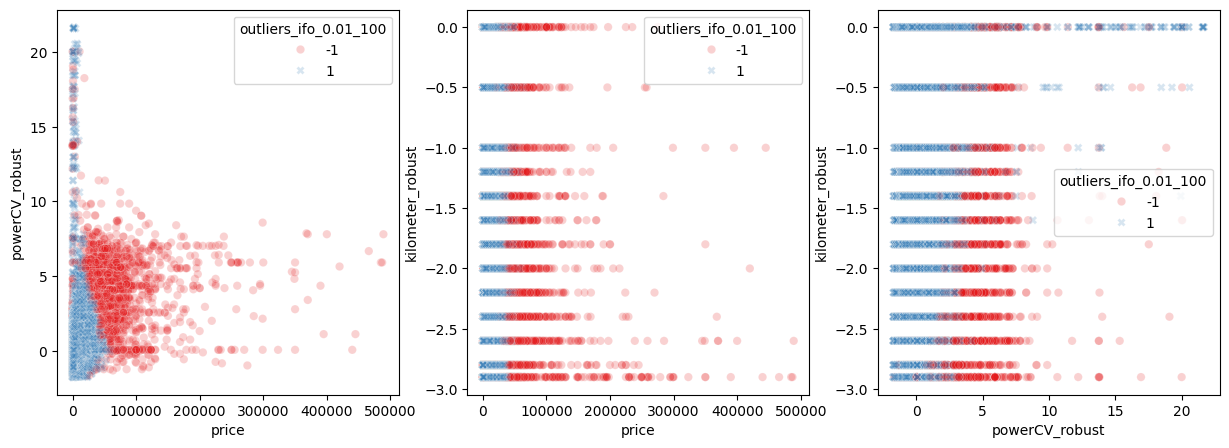

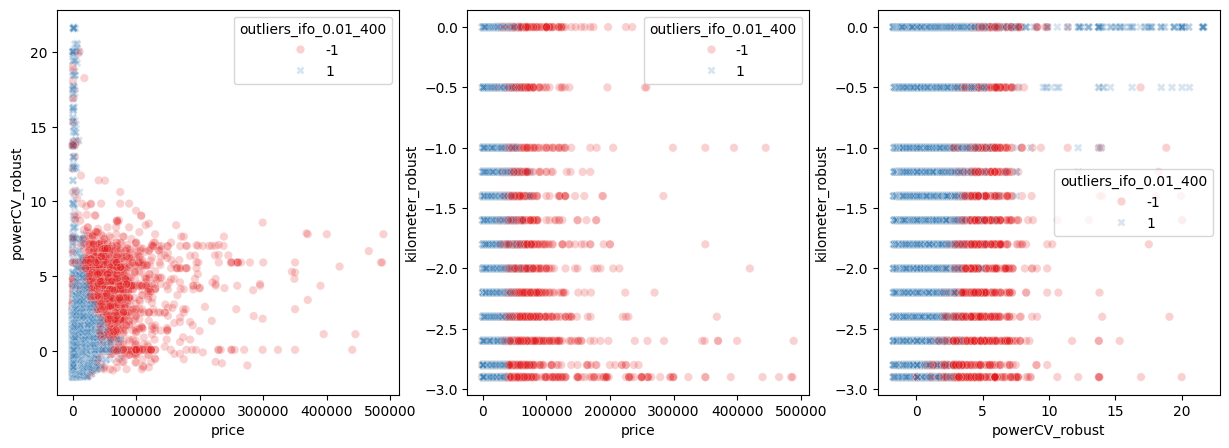

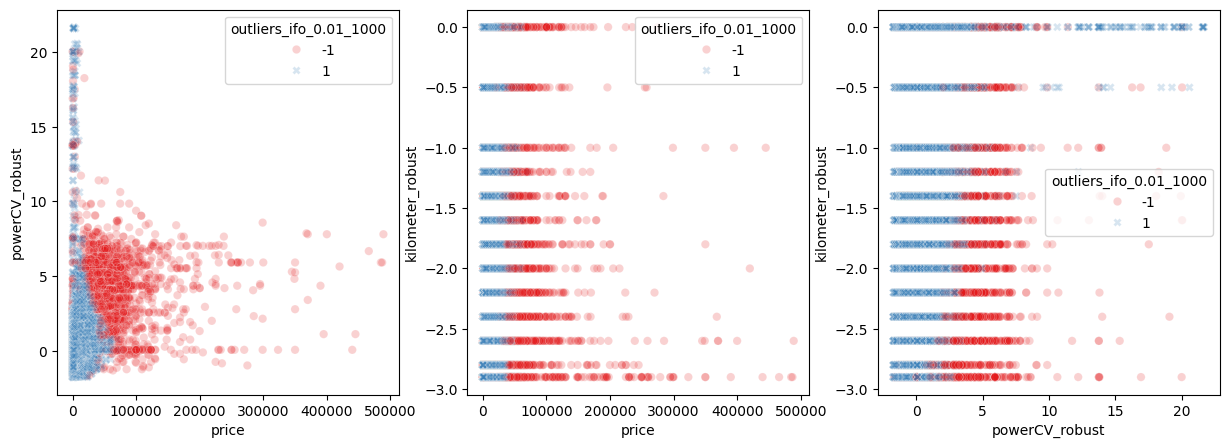

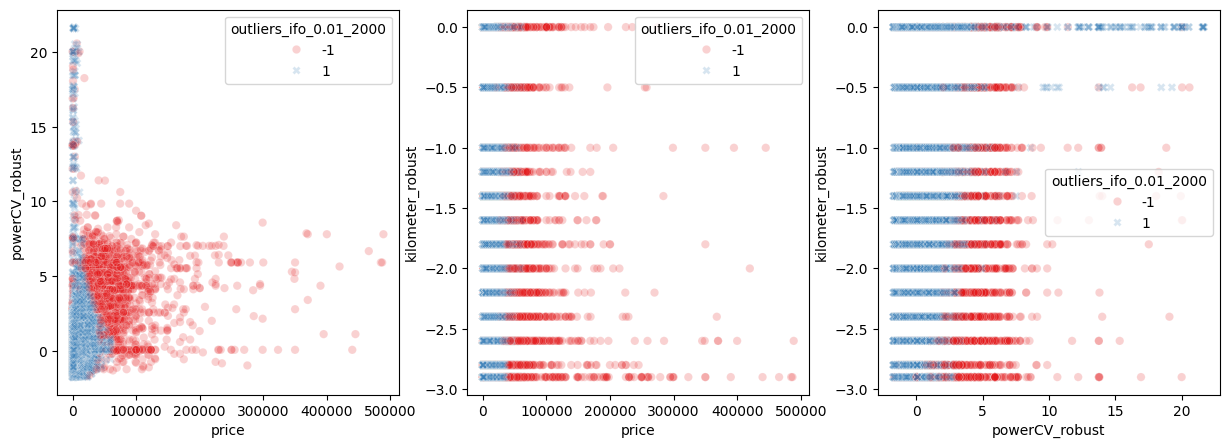

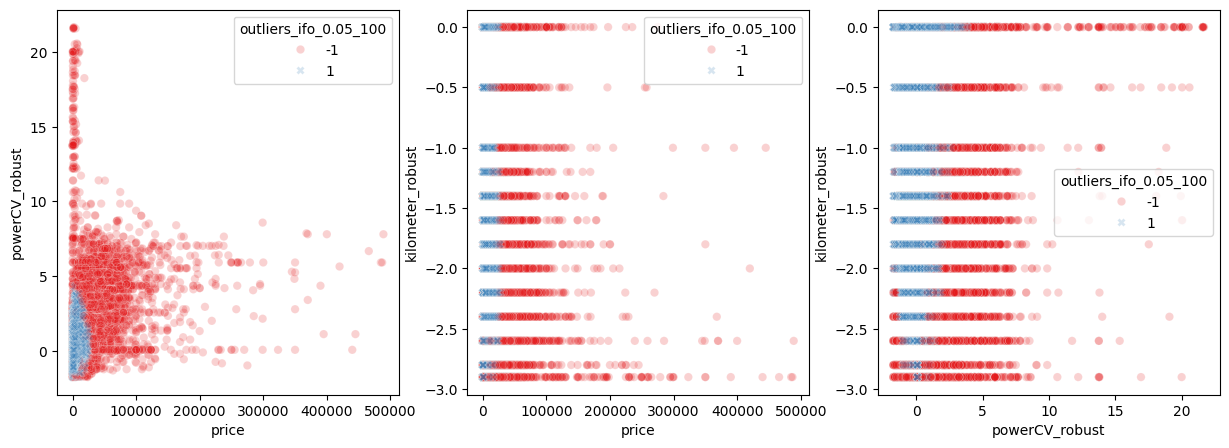

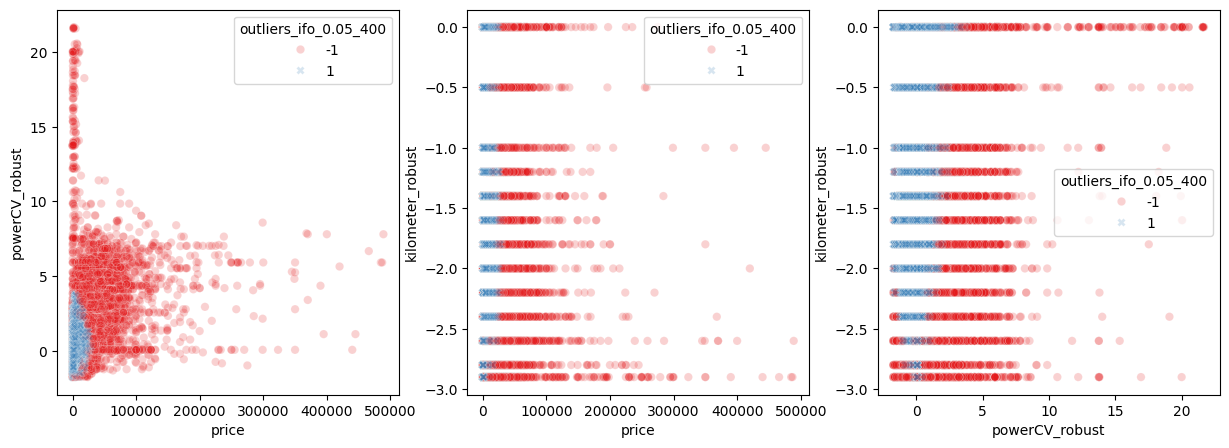

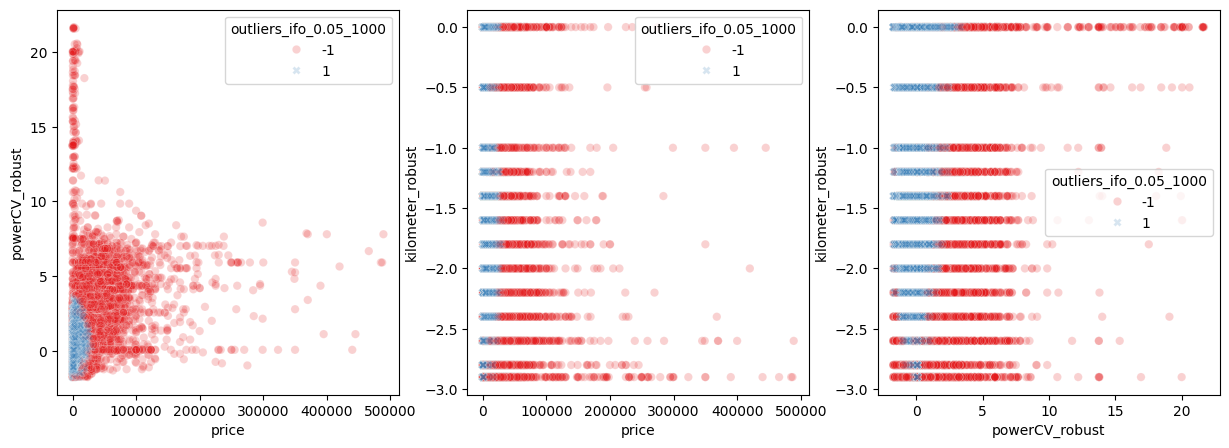

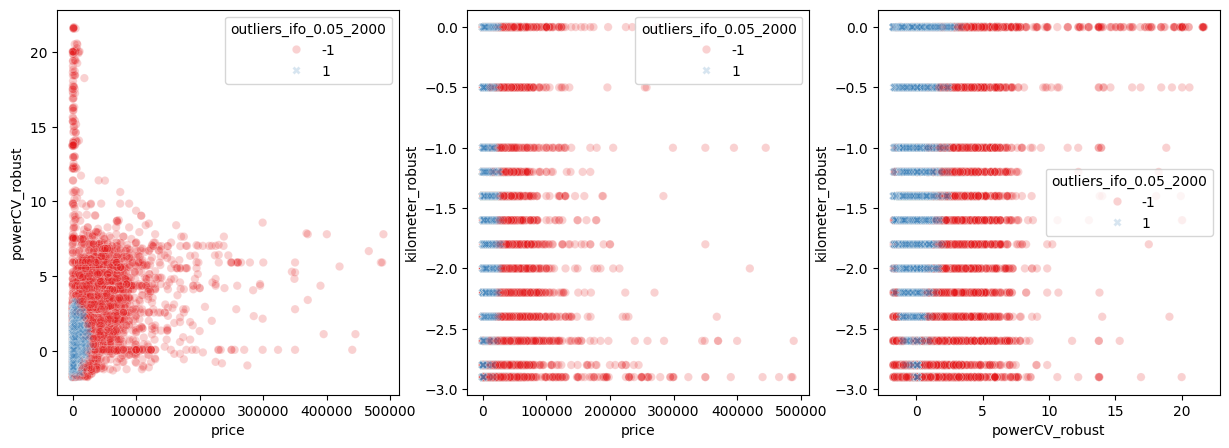

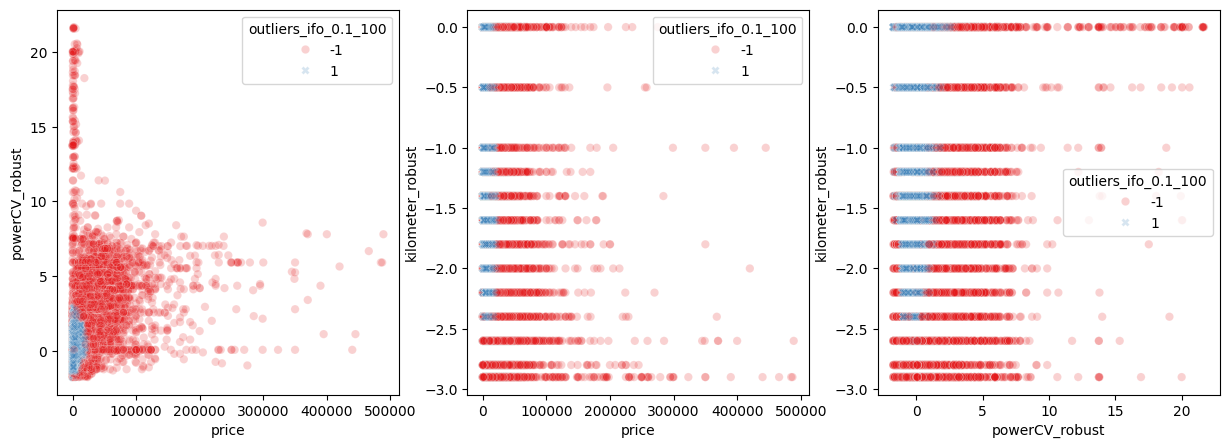

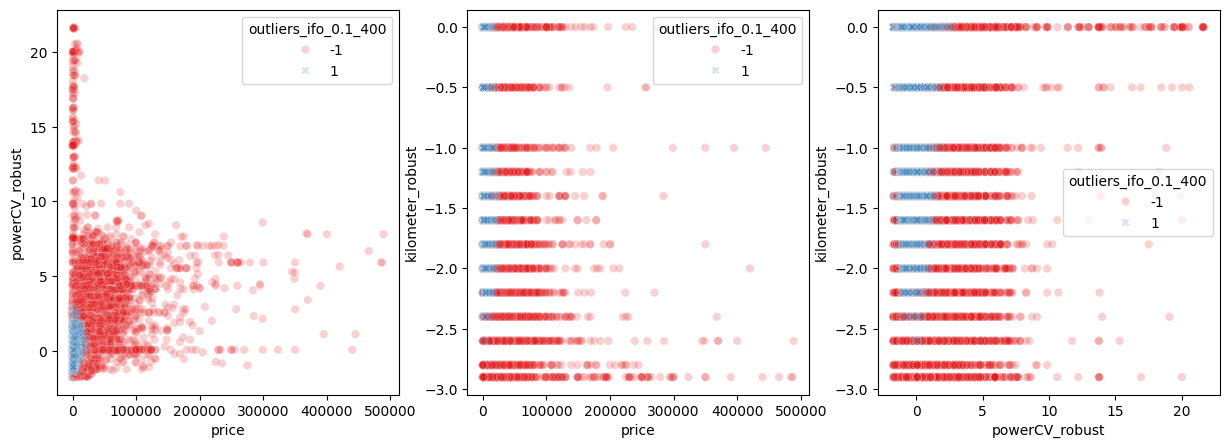

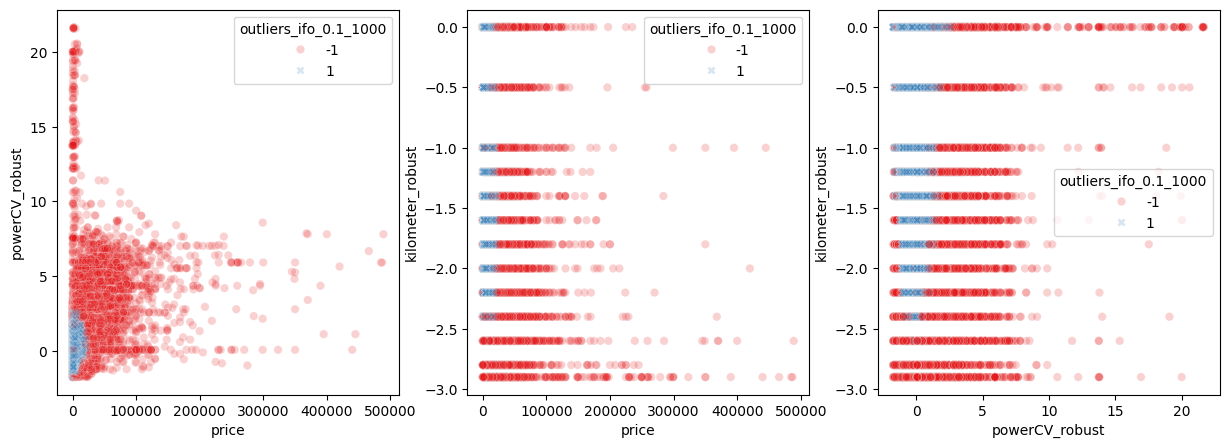

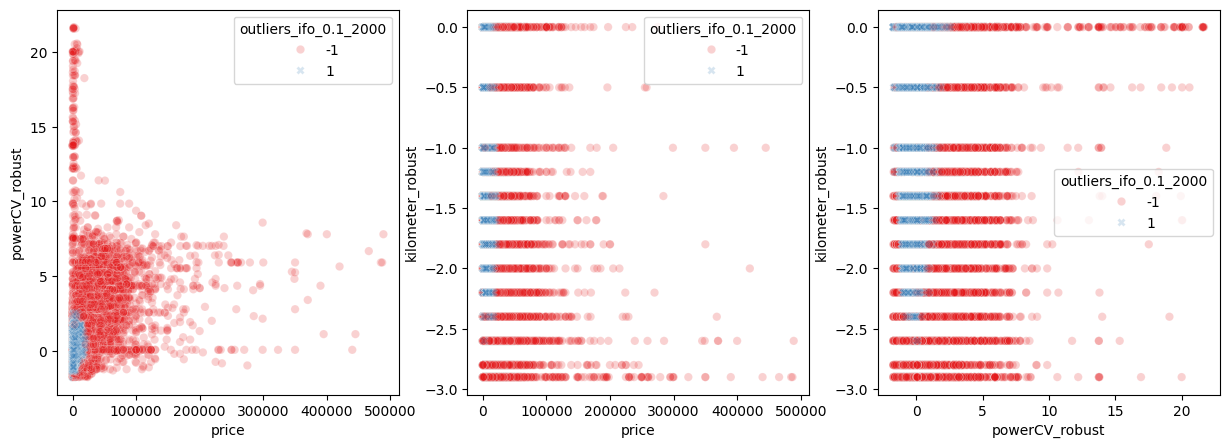

In [32]:
combinaciones_visual=list(combinations(["price","powerCV_robust","kilometer_robust"], 2))

for out in columnas_hue:


    fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(15,5))
    axes=axes.flat
    for indice, tupla in enumerate(combinaciones_visual):
        sns.scatterplot(x=tupla[0], y=tupla[1], ax= axes[indice], data=df_robust, hue= out, palette= "Set1", alpha= 0.2, style= out)

Observamos como a mayor número de arboles los outliers se van agrupando más.  
Además según vamos siendo más estrictos con el nivel de contaminación, más sentido tiene la interpretación. 
Un ejemplo de esto es la conclusión del scaterplot entre los kilometros y la potencia. En este ejemplo se puede ver como los valores no outliers son a partir de lo que corresponde a unos 40.000km (además vamos viendo como van aumentando el número de vehículos según vamos yendo a kilometrajes más altos) y en el caso de la potencia se concentran entre las potencias bajas y los 180 caballos de potencia aproximadamente.  
  
Por otra parte, en los otros dos scatterplots, observamos como en el caso del precio los datos no outliers se encuentran entre 0 y los 23.000 € aproximadamente.

In [ ]:
df_robust.head()

,AdministrativeDuration,Informational,InformationalDuration,ProductRelatedDuration,ExitRates,PageValues,Month,OperatingSystems,Browser,Region,...,outliers_ifo1,outliers_ifo10.01_10,outliers_ifo10.01_100,outliers_ifo10.01_200,outliers_ifo10.05_10,outliers_ifo10.05_100,outliers_ifo10.05_200,outliers_ifo10.1_10,outliers_ifo10.1_100,outliers_ifo10.1_200
0,-0.028789,0.0,0.0,-0.467912,4.895621,0.0,Feb,MacOS,Mozilla Firefox,Region1,...,1,1,1,1,1,1,1,1,1,1
1,-0.028789,0.0,0.0,-0.417913,2.095621,0.0,Feb,Windows,Google Chrome,Region1,...,1,1,1,1,1,1,1,1,1,1
2,-0.028789,0.0,0.0,-0.467912,4.895621,0.0,Feb,iOS,Mozilla Firefox,Region9,...,1,1,1,1,1,1,1,1,1,1
3,-0.028789,0.0,0.0,-0.465829,3.215621,0.0,Feb,Linux,Google Chrome,Unknown,...,1,1,1,1,1,1,1,1,1,1
4,-0.028789,0.0,0.0,0.022315,0.695621,0.0,Feb,Linux,Tor,Region1,...,1,1,1,1,1,1,1,1,1,1


A pesar de que las gráficas tienen sentido debido a la dispersión y cantidad de los datos es más correcto un LOF

In [ ]:
lista_contaminaciones = [0.01, 0.05, 0.1]
lista_neighbors = [20, 35, 50]

combinaciones = list(product(lista_contaminaciones, lista_neighbors))
combinaciones


for cont, neighbors in tqdm(combinaciones):
    lof = LocalOutlierFactor(n_neighbors=neighbors,
                            contamination=cont,
                            n_jobs=-1)

    df_robust[f"outliers_lof_{cont}_{neighbors}"] = lof.fit_predict(df_robust[["price", "powerCV_robust", "kilometer_robust"]])
    y_pred = lof.fit_predict(df_robust[["price", "powerCV_robust", "kilometer_robust"]])
df_robust

# Visualizacion
columnas_hue = df_robust.filter(like="outlier").columns

combinaciones_viz = list(combinations(["price", "powerCV_robust", "kilometer_robust"], 2))
combinaciones_viz

for outlier in columnas_hue:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15, 5))
    axes = axes.flat

    for indice, tupla in enumerate(combinaciones_viz):
        sns.scatterplot(x = tupla[0],
                        y = tupla[1],
                        ax = axes[indice],
                        data = df_robust,
                        hue=outlier,
                        palette="Set1",
                        style=outlier,
                        alpha=0.5)
        
    plt.suptitle(outlier)

  0%|          | 0/9 [00:00<?, ?it/s]